# Homework 1 ATED - Group 1

In [56]:
%pylab inline
import math
import time
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import scipy.stats as scs
import statsmodels.api as sm
from scipy.integrate import quad

Populating the interactive namespace from numpy and matplotlib


/home/louis/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['size', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## HW1-1

#### You are short 100 at-the-money call option contracts on the S&P 500 index expiring in one year with a contract multiplier of 100. The current index level is 2600, the interest and dividend rates are zero.

##### Simulate the evolution of the index level at periods Δt as a geometric Brownian motion with volatility $\sigma$ (free parameter) and calculate the corresponding call value, delta, gamma and theta using a fixed 20 % implied volatility.

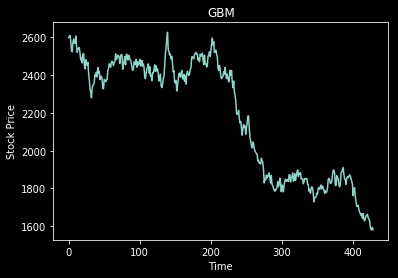

In [66]:
def simulate_gbm(vol):
    #model parameters
    S0 = 2600 #initial S&P500 index level
    T = 1
    
    #simulate parameters
    #np.random.seed(100000)
    gbm_dates = pd.DatetimeIndex(start = '13-04-2018', end = '12-04-2019', freq = 'B')
    M = len(gbm_dates) #time steps
    I = 1 #index level paths
    dt = 1/252 
    df = 1 #discount factor is 1 because interest rate is 0
    
    #stock price paths
    rand = np.random.standard_normal((M,I))#random numbers
    S = np.zeros_like(rand) #stock matrix
    S[0] = S0 #initial index
    for t in range(1,M): 
        S[t] = S[t-1] * np.exp((-vol**2/2) * dt + vol * rand[t] *math.sqrt(dt))
    gbm = pd.DataFrame(S[:,0], index = gbm_dates, columns = ['index'])
    return gbm

vol = np.random.uniform(0,0.35)
sim = simulate_gbm(vol)
plt.plot(sim.values)
plt.xlabel('Time')
plt.ylabel(r'Stock Price')
plt.title('GBM')
plt.show()

In [67]:
def dN(x):
    #probability density function of standard normal random variable x
    return math.exp(-0.5*x**2)/math.sqrt(2*math.pi)

def N(d):
    #cumulative density function of standard normal random variable x
    return quad(lambda x:dN(x),-20,d,limit=50)[0]

def d1f(St,K,t,T,r,sigma):
    #B-S d1 function
    d1 = (math.log(St/K)+(r+0.5*sigma**2)*(T-t))/(sigma*math.sqrt(T-t))
    return d1

def d2f(St,K,t,T,r,sigma):
    #B-S d2 function
    return (d1f(St,K,t,T,r,sigma) - sigma * sqrt(T-t))

def BSM_delta(St,K,t,T,r,sigma):
    #BS delta of European call
    d1 = d1f(St,K,t,T,r,sigma)
    delta = N(d1)
    return delta
    
def BSM_gamma(St,K,t,T,r,sigma):
    #BS gamma of European call
    d1 = d1f(St,K,t,T,r,sigma)
    gamma = dN(d1)/(St*sigma*math.sqrt(T-t))
    return gamma

def BSM_theta(St,K,t,T,r,sigma):
    d1 = d1f(St,K,t,T,r,sigma)
    d2 = d1 - sigma*math.sqrt(T-t)
    theta = -(St*dN(d1)*sigma/(2*math.sqrt(T-t))+r*K*math.exp(-r*(T-t)*N(d2)))
    return theta

def BSCall(St,K,t,T,r,sigma):
    return(St * N(d1f(St,K,t,T,r,sigma)) - K * exp(-r*(T-t)) * N(d2f(St,K,t,T,r,sigma)))

In [151]:
stockPath=sim.values
size=len(stockPath)
K,T,r,sigma = stockPath[0], 1, 0, vol

Price of one call today: [207.10475384]


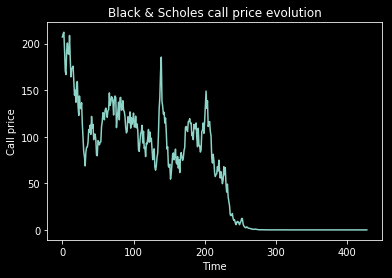

In [127]:
callPrices=np.array([BSCall(x,K,i/size,T,r,sigma) for i,x in enumerate(stockPath)])
print('Price of one call today:', callPrices[0])
plt.plot(callPrices)
plt.xlabel('Time')
plt.ylabel(r'Call price')
plt.title('Black & Scholes call price evolution')
plt.show()

Delta of one call today: 0.539827837277029


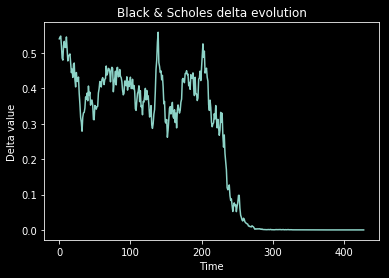

In [128]:
deltas=np.array([BSM_delta(x,K,i/size,T,r,sigma) for i,x in enumerate(stockPath)])
print('Delta of one call today:', deltas[0])
plt.plot(deltas)
plt.xlabel('Time')
plt.ylabel(r'Delta value')
plt.title('Black & Scholes delta evolution')
plt.show()

Gamma of one call today: [0.00076337]


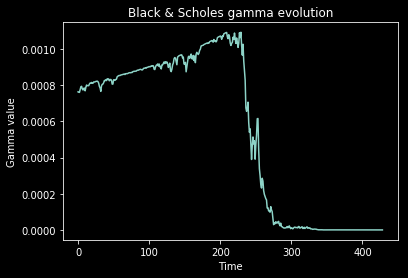

In [129]:
gammas=np.array([BSM_gamma(x,K,i/size,T,r,sigma) for i,x in enumerate(stockPath)])
print('Gamma of one call today:', gammas[0])
plt.plot(gammas)
plt.xlabel('Time')
plt.ylabel(r'Gamma value')
plt.title('Black & Scholes gamma evolution')
plt.show()

Theta of one call today: [-103.20766234]


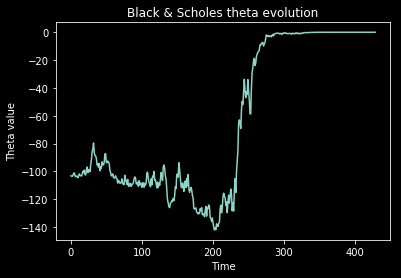

In [130]:
thetas=np.array([BSM_theta(x,K,i/size,T,r,sigma) for i,x in enumerate(stockPath)])
print('Theta of one call today:', thetas[0])
plt.plot(thetas)
plt.xlabel('Time')
plt.ylabel(r'Theta value')
plt.title('Black & Scholes theta evolution')
plt.show()

##### Then simulate your actual cumulative P&L when periodically delta-hedging your position (assuming you can trade the index as an asset) and compare it against the proxy formula on slide 11 for the following matrix of parameters.

In [122]:
def actualPandLDeltaHedging(nbCalls, stckPath, frq, IV):
    cumPL = 0
    nbStocksinPortfolio = 0
    dt = 1/frq
    for i in range(frq):
        nbStockstoHave = BSM_delta(stckPath[i],stckPath[0], i*dt,1,0,IV)
        nbStockstoBuy = nbStockstoHave - nbStocksinPortfolio
        nbStocksinPortfolio = nbStockstoHave
        
        cumPL -= stockPath[i] * nbStockstoBuy
    return nbCalls * cumPL

In [154]:
def proxyPandLDeltaHedging(nbCalls, stckPath, IV, frq):
    cumPL = 0
    dt = 1/frq
    for i in range(frq):
        cumPL += BSM_gamma(stckPath[i],stckPath[0], i*dt,1,0,IV) * stckPath[i]**2 * (((stckPath[i+1]/stckPath[i]) - 1)**2 - (IV * sqrt((i+1) * dt))**2)
    return nbCalls * cumPL/2

In [155]:
impliedVol = 0.25
nbCalls = -100

actualM, actualW, actualD = actualPandLDeltaHedging(nbCalls, stockPath, 12, impliedVol), actualPandLDeltaHedging(nbCalls, stockPath, 52, impliedVol), actualPandLDeltaHedging(nbCalls, stockPath, 252, impliedVol)
print('Actual P&L weekly, monthly and daily:', actualM, actualW, actualD)
proxyM, proxyW, proxyD = proxyPandLDeltaHedging(nbCalls, stockPath, impliedVol, 12), proxyPandLDeltaHedging(nbCalls, stockPath, impliedVol, 52), proxyPandLDeltaHedging(nbCalls, stockPath, impliedVol, 252)
print('Proxy P&L weekly, monthly and daily:', proxyM, proxyW, proxyD)

Actual P&L weekly, monthly and daily: [112680.07758338] [13344.98482428] [19419.81913224]
Proxy P&L weekly, monthly and daily: [160314.6632111] [440476.22713486] [2141358.38902559]


In [157]:
impliedVol = 0.20
nbCalls = -100

actualM, actualW, actualD = actualPandLDeltaHedging(nbCalls, stockPath, 12, impliedVol), actualPandLDeltaHedging(nbCalls, stockPath, 52, impliedVol), actualPandLDeltaHedging(nbCalls, stockPath, 252, impliedVol)
print('Actual P&L weekly, monthly and daily:', actualM, actualW, actualD)
proxyM, proxyW, proxyD = proxyPandLDeltaHedging(nbCalls, stockPath, impliedVol, 12), proxyPandLDeltaHedging(nbCalls, stockPath, impliedVol, 52), proxyPandLDeltaHedging(nbCalls, stockPath, impliedVol, 252)
print('Proxy P&L weekly, monthly and daily:', proxyM, proxyW, proxyD)

Actual P&L weekly, monthly and daily: [106732.06242046] [11882.07698973] [19820.66930221]
Proxy P&L weekly, monthly and daily: [127465.4867382] [299667.1751738] [1568084.90571673]


In [158]:
impliedVol = 0.15
nbCalls = -100

actualM, actualW, actualD = actualPandLDeltaHedging(nbCalls, stockPath, 12, impliedVol), actualPandLDeltaHedging(nbCalls, stockPath, 52, impliedVol), actualPandLDeltaHedging(nbCalls, stockPath, 252, impliedVol)
print('Actual P&L weekly, monthly and daily:', actualM, actualW, actualD)
proxyM, proxyW, proxyD = proxyPandLDeltaHedging(nbCalls, stockPath, impliedVol, 12), proxyPandLDeltaHedging(nbCalls, stockPath, impliedVol, 52), proxyPandLDeltaHedging(nbCalls, stockPath, impliedVol, 252)
print('Proxy P&L weekly, monthly and daily:', proxyM, proxyW, proxyD)

Actual P&L weekly, monthly and daily: [97500.93476387] [11020.10116849] [20676.18797647]
Proxy P&L weekly, monthly and daily: [94232.75860654] [173572.37531746] [1009669.62406392]


##### Provide a statistical analysis of your results over 10,000 simulations, where one simulation is an entire index path.

In [ ]:
nbCalls = - 100

def statisticsMultiplePandLSim(N=10000):
    res = np.empty((10000,18))
    
    for i in range(N):
        #Simulation
        vol = np.random.uniform(0,0.35)
        sim = simulate_gbm(vol)
        
        #Stock and calls
        stockPath = sim.values
        callPrices = np.array([BSCall(x,K,i/size,T,r,sigma) for i,x in enumerate(stockPath)])
        
        #Monthly
        res[i,0] = actualPandLDeltaHedging(nbCalls, stockPath, 12, 0.25)
        res[i,1] = actualPandLDeltaHedging(nbCalls, stockPath, 12, 0.20)
        res[i,2] = actualPandLDeltaHedging(nbCalls, stockPath, 12, 0.15)
        res[i,3] = proxyPandLDeltaHedging(nbCalls, stockPath, 0.25, 12)
        res[i,4] = proxyPandLDeltaHedging(nbCalls, stockPath, 0.20, 12)
        res[i,5] = proxyPandLDeltaHedging(nbCalls, stockPath, 0.15, 12)
        
        #Weekly
        res[i,6] = actualPandLDeltaHedging(nbCalls, stockPath, 52, 0.25)
        res[i,7] = actualPandLDeltaHedging(nbCalls, stockPath, 52, 0.20)
        res[i,8] = actualPandLDeltaHedging(nbCalls, stockPath, 52, 0.15)
        res[i,9] = proxyPandLDeltaHedging(nbCalls, stockPath, 0.25, 52)
        res[i,10] = proxyPandLDeltaHedging(nbCalls, stockPath, 0.20, 52)
        res[i,11] = proxyPandLDeltaHedging(nbCalls, stockPath, 0.15, 52)
        
        #Daily
        res[i,12] = actualPandLDeltaHedging(nbCalls, stockPath, 252, 0.25)
        res[i,13] = actualPandLDeltaHedging(nbCalls, stockPath, 252, 0.20)
        res[i,14] = actualPandLDeltaHedging(nbCalls, stockPath, 252, 0.15)
        res[i,15] = proxyPandLDeltaHedging(nbCalls, stockPath, 0.25, 252)
        res[i,16] = proxyPandLDeltaHedging(nbCalls, stockPath, 0.20, 252)
        res[i,17] = proxyPandLDeltaHedging(nbCalls, stockPath, 0.15, 252)
    
    return np.mean(res,axis=0), np.var(res,axis=0)

statisticsMultiplePandLSim()

For the results of this analysis, please refer to the pdf report.

## HW1-3

#### On March 29, 2018 the S$\&$P 500 index (SPX) is 2611.53 and the 12-month VIX is 21.28. The implied volatility smile of SPX options expiring on March 15, 2019 is given as:
$$ \sigma^* = \sqrt{a + b \left( \rho (x - m)  + \sqrt{(x-m)^2 + s^2} \right)} $$
#### where $a = 0.009$, $b = 0.11$, $\rho = −0.12$, $m = 0.2$, $s = 0.05$, $x = \log \frac{K}{F}$ is log-moneyness and $F = 2625.10$ is the forward price. The continuous interest rate is 2.09 % p.a.

##### Draw the implied volatility smile curve for strikes $500 \leq K \leq 5000$.

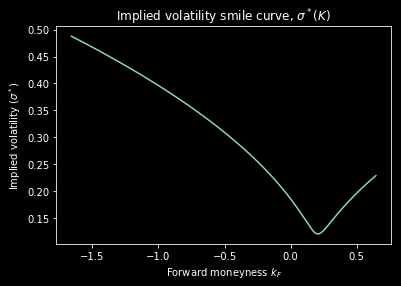

In [18]:
a, b, rho, m, s = .009, .11, -.12, .2, .05
s2, F, r = s**2, 2625.10, .0209
strikes = np.arange(500, 5000, 1)
moneyness = np.array(np.log(strikes/F))

impliedVolSVImodel = lambda x : np.sqrt(a + b * (rho * (x - m) + np.sqrt((x-m)**2 + s**2)))
sviSmile = [impliedVolSVImodel(m) for m in moneyness]

plt.plot(moneyness, sviSmile)
plt.xlabel('Forward moneyness $k_F$')
plt.ylabel(r'Implied volatility $(\sigma^*)$')
plt.title('Implied volatility smile curve, $\sigma^*(K)$')
plt.show()

##### Calculate the fair strike $K_{var}$ of a variance swap expiring on March 15, 2019 with the method of your choice. How close is your calculation to the 12-month VIX? Why is it not exactly the same?

In [100]:
def fractionalSums(df, o) :
    if (o == 1) : # Call options
        df = df.loc[df['Strike'] >= F]
    else :
        df = df.loc[df['Strike'] <= F]
    deltaK = df[['Strike']].diff()
    deltaK.iloc[0] = deltaK.iloc[1]
    
    sum = 0.0
    for i in np.arange(len(df)) :
        sum += df.iat[i,1] * deltaK.iloc[i]['Strike'] / (df.iat[i,0]**2)
    return(sum)

puts = pd.read_excel('SPX_optionsData.xlsx', sheetname = 'Data_Put')
calls = pd.read_excel('SPX_optionsData.xlsx', sheetname = 'Data_Call')

In [105]:
T = 1
K_var = 100*math.sqrt(2*math.exp(r*T)/T * (fractionalSums(puts, -1) + fractionalSums(calls, 1)))
print(K_var, 21.28-K_var)

19.034461743021915 2.2455382569780866


The computation for $K_{var}$ is quite close to the 12-month VIX.
$$VIX-K_{var}=21.28-19.03=2.25$$